# Energy Portfolio Management for Sustainable Campus


Add problem description...

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import utils
from datetime import datetime, timedelta

## Parameters

In [2]:
T = 96                                   # Number of periods
nScenarios = 5                           # Number of scenarios

# Contract prices
P  = np.array([150, 360, 200, 50]) # Contract prices [$\MW]
pF = 18/4                          # option excercise fee [$\MW(h\4)]

Cw = 20                            # Maximum wind generator capacity
Cg = 10                            # Maximum gas generator capacity
Cs = 1                             # Maximum solar generator capacity

t = np.array(range(T))             # Periods
h = t//4                           # Hour of the day
peakHour = ((h>=8)*(h<18))         # Indicator for peak hour (8AM-6PM)

pr = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Probability of each scenario

beta = 0.8

We load the demand and generation data from each scenario

In [3]:
scenarios = ["scenarios/Scenario1.csv","scenarios/Scenario2.csv",
            "scenarios/Scenario3.csv","scenarios/Scenario4.csv",
            "scenarios/Scenario5.csv"]
T = 96                                   # Number of periods
nScenarios = 5                           # Number of scenarios
demand = np.empty([T,nScenarios])
windPF = np.empty([T,nScenarios])
solarPF = np.empty([T,nScenarios])
rtPrice = np.empty([T,nScenarios])

for i in range(nScenarios):
    scenario = pd.read_csv(scenarios[i])
    demand[:,i] = scenario.iloc[:T,1]/1000
    windPF[:,i] = scenario.iloc[:T,2]
    solarPF[:,i] = scenario.iloc[:T,3]
    rtPrice[:,i] = scenario.iloc[:T,4]/4

## Problem formulation

We will write the problem in matrix form as:
$$\min_{x,y,\alpha,M} \alpha + \sum_{\omega}M_{\omega},\,\,\mbox{s.t.}\, Ax\leq By+C,\, Dy\leq E, M_{\omega}\geq P'y+{R_{\omega}}'x-\alpha $$

For the definition of the matrices $A, B, C, D, E$ and $P$, and decision variables $x$ and $y$, please refer to the jupyter notebook named "Cost_Minimization" or to the project report. Here we'll focus on $\alpha, M$ and $R_{\omega}$.

The matrix $R_{\omega}$ contains the vector of prices in scenario $\omega$, and $0$ in scenarios different than $\omega$. This allows us to write the total cost in scenario $\omega$ as
$$P'y+{R_{\omega}}'x.$$

The variable $\alpha$ is the cost in the second worst case scenario. This implies that the objective function
$$\alpha + \sum_{\omega}M_{\omega}$$
is exactly equal to the worst case cost. The variables $M_{\omega}$ help formulating the optimization problem. In particular, they help us implementing the non-linear function $[\cdot]^+$ "positive part of" using only linear constraints. At the optimal solution, we expect all $M_{\omega}$ to be zero, except in the worst case scenario.

In [4]:
# Decision variables
x = cp.Variable(2*T*nScenarios)
y = cp.Variable(4,nonneg = True)
M = cp.Variable(nScenarios,nonneg = True)
alpha = cp.Variable(1)

In [5]:
# Constraints

# Matrices A, B and C

A = np.zeros([3*T*nScenarios,2*T*nScenarios])
B = np.zeros([3*T*nScenarios,4])
C = np.zeros([3*T*nScenarios,1])

# Matrices R_{\omega}
Rs1 = np.zeros([2*T*nScenarios,1])
Rs2 = np.zeros([2*T*nScenarios,1])
Rs3 = np.zeros([2*T*nScenarios,1])
Rs4 = np.zeros([2*T*nScenarios,1])
Rs5 = np.zeros([2*T*nScenarios,1])

# First set of constraints x^o_{wt} \leq y_4
A[:(T*nScenarios),:(T*nScenarios)] = np.identity(T*nScenarios)
B[:(T*nScenarios),3] = 1 

# Second set of constraints x^o_{wt} \geq 0
A[(T*nScenarios):(2*T*nScenarios),
  :(T*nScenarios)] = -np.identity(T*nScenarios)

for i in range(nScenarios):
      
    # Third set of constraints 
    # -x^o_{wt}-x^m_{wt} \leq -demand + solar + wind + base_load + peak_load
    A[(2*T*nScenarios+T*i):(2*T*nScenarios+T*(i+1)),
     (T*i):(T*(i+1))] = - np.identity(T) 
    
    A[(2*T*nScenarios+T*i):(2*T*nScenarios+T*(i+1)),
     (T*nScenarios+T*i):(T*nScenarios+T*(i+1))] = - np.identity(T) 
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),0] = (windPF[:,i])
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),1] = np.ones(T)
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),2] = peakHour
    
    C[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),0] =  Cs*solarPF[:,i]-demand[:,i]
    
    
    # Costs in bjective function Q1: option fee, Q2: market price
    R1 = np.ones((T,1))*pF
    R2 = rtPrice[:,i]
    
    if (i == 0):
        Rs1[(T*i):(T*(i+1)),:] = R1
        Rs1[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = R2.reshape((T, 1))
    elif (i == 1):
        Rs2[(T*i):(T*(i+1)),:] = R1
        Rs2[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = R2.reshape((T, 1))
    elif (i == 2):
        Rs3[(T*i):(T*(i+1)),:] = R1
        Rs3[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = R2.reshape((T, 1))
    elif (i == 3):
        Rs4[(T*i):(T*(i+1)),:] = R1
        Rs4[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = R2.reshape((T, 1))
    elif (i == 4):
        Rs5[(T*i):(T*(i+1)),:] = R1
        Rs5[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = R2.reshape((T, 1))
    

The matrices $D$ and $E$ codify two constraints:
* Gas generator capacity $$y_1+y_2+y_3\leq C^g$$
* Wind generator capacity $$y_0\leq C^w$$

In [6]:
# Matrices D and E
D = np.array([[0,1,1,1],[1,0,0,0]])
E = np.array([[Cg],[Cw]])

The objective function minimizes costs

In [7]:
obj = cp.Minimize(alpha + sum(M))

We add the constraints

In [8]:
# Initialize an empty constraint set
con_set_1 = [] 

con_set_1.append(A@x <= B@y + C.flatten())
con_set_1.append(D@y <= E.flatten())

con_set_1.append(M[0] >= P@y + np.transpose(Rs1)@x - alpha)
con_set_1.append(M[1] >= P@y + np.transpose(Rs2)@x - alpha)
con_set_1.append(M[2] >= P@y + np.transpose(Rs3)@x - alpha)
con_set_1.append(M[3] >= P@y + np.transpose(Rs4)@x - alpha)
con_set_1.append(M[4] >= P@y + np.transpose(Rs5)@x - alpha)

Now we solve the optimization problem

In [9]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();

Academic license - for non-commercial use only - expires 2022-01-02
Using license file C:\Users\Rob\gurobi.lic


In [10]:
print("\n The optimal wind capacity is: %.1f" % (y[0].value))
print("\n The optimal base capacity from the gas generator is: %.1f" % (y[1].value))
print("\n The optimal peak capacity from the gas generator is: %.1f" % (y[2].value))
print("\n The optimal load following capacity from the gas generator is: %.1f" % (y[3].value))
print("\n alpha = %.1f" % (alpha.value))
for i in range(nScenarios):
    print("\n M["+ str(i) +"] = %.1f" % (M[i].value))


 The optimal wind capacity is: 0.0

 The optimal base capacity from the gas generator is: 10.0

 The optimal peak capacity from the gas generator is: 0.0

 The optimal load following capacity from the gas generator is: 0.0

 alpha = 3021.2

 M[0] = 0.0

 M[1] = 0.0

 M[2] = 0.2

 M[3] = 0.0

 M[4] = 0.0


In [11]:
data_all = utils.GetAllVariables(x,y,demand,windPF,solarPF,Cs,nScenarios,peakHour,rtPrice,T)

data_all.to_csv("outputs/Results_min_worst_case_cost.csv")

data_all.head()

,Demand_s1,GasBase_s1,GasOption_s1,GasPeak_s1,SolarPower_s1,SpotMarket_s1,WindPower_s1,Demand_s2,GasBase_s2,GasOption_s2,...,SolarPower_s4,SpotMarket_s4,WindPower_s4,Demand_s5,GasBase_s5,GasOption_s5,GasPeak_s5,SolarPower_s5,SpotMarket_s5,WindPower_s5
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.37568,10.0,1.293079e-11,0.0,0.0,-2.479565,0.0,7.48512,10.0,1.270080e-11,...,0.0,-2.309708,0.0,7.58880,10.0,1.224442e-11,0.0,0.0,-2.088310,0.0
2021-01-01 00:15:00,7.31808,10.0,1.307240e-11,0.0,0.0,-2.542559,0.0,7.43328,10.0,1.280251e-11,...,0.0,-2.351044,0.0,7.51968,10.0,1.287063e-11,0.0,0.0,-2.205756,0.0
2021-01-01 00:30:00,7.32960,10.0,1.283607e-11,0.0,0.0,-2.521778,0.0,7.42464,10.0,1.269805e-11,...,0.0,-2.376822,0.0,7.49376,10.0,1.250687e-11,0.0,0.0,-2.216094,0.0
2021-01-01 00:45:00,7.32960,10.0,1.244785e-11,0.0,0.0,-2.499313,0.0,7.37568,10.0,1.272646e-11,...,0.0,-2.378160,0.0,7.46208,10.0,1.215857e-11,0.0,0.0,-2.200484,0.0
2021-01-01 01:00:00,7.28064,10.0,1.279455e-11,0.0,0.0,-2.568962,0.0,7.35552,10.0,1.279884e-11,...,0.0,-2.381653,0.0,7.40736,10.0,1.207395e-11,0.0,0.0,-2.237850,0.0


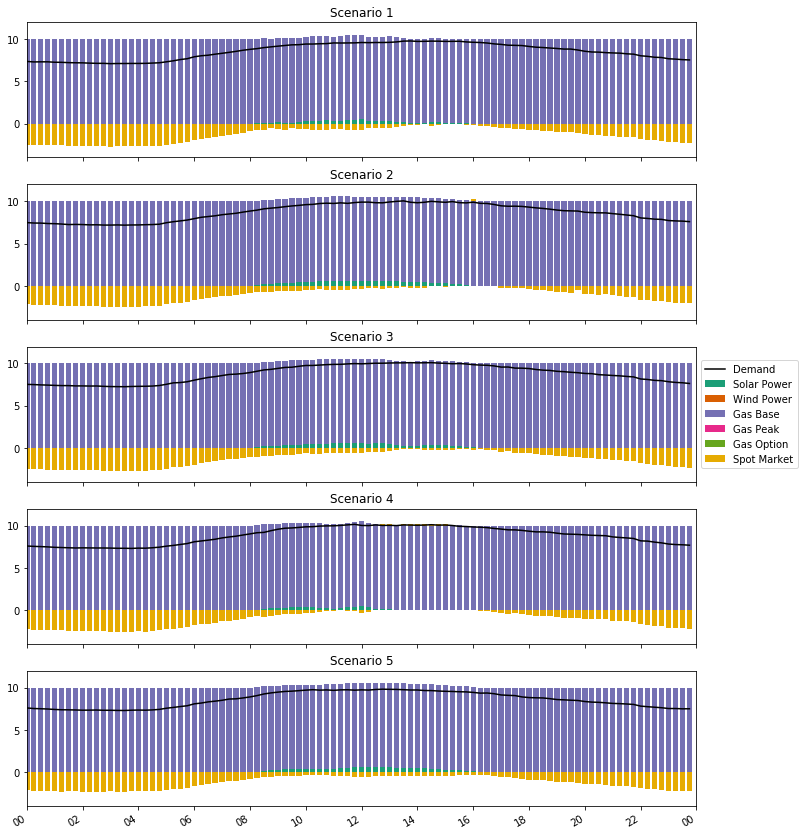

In [12]:
utils.PlotEnergyMix(x,y,demand,windPF,solarPF,Cs,nScenarios,peakHour,rtPrice,T,"outputs/min_worst_case_cost")

In [13]:
obj.value

3021.488830800816